In [44]:
import warnings
warnings.filterwarnings("ignore")

in case of low memory: work with low sample

# Import Libraries

## Library versions

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# pip install geopy
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, plot_roc_curve, roc_curve, confusion_matrix, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,learning_curve, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from lightgbm import plot_importance

# Import Datasets & merge

In [20]:
path = 'processo_cientista-master/data/'

data = pd.read_csv(path+'rain_data_aus.csv')
winds = pd.DataFrame()

for number in [1,2,3,4,5,6,7,8]:
    df = pd.read_csv(path+f'wind_table_0{number}.csv')
    df.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    winds = pd.concat([winds,df])

data = pd.merge(data, winds, on=['date','location'])

data = data.drop_duplicates()

# Exploring Data

## **Analysis of *modelo_vigente***

Here we can analyse if the *modelo_vigente* would be the probability of raining in the next day.
In other words, woud be the prediction of the column *raintomorrow*

In [ ]:
# verificar futuramente: a distribuição dessas probabilidades.
# isso ajudaria analisar qual seria o "corte" ideal do modelo.
# cuidado com a organização do nome das variáveis.

In [34]:
testi = data.loc[:,['raintomorrow','modelo_vigente']]

In [35]:
testi['prev'] = testi.modelo_vigente.apply(lambda x: x > 0.5)
testi['real'] = testi.raintomorrow.apply(lambda x: x == 'Yes')

In [36]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(testi.iloc[:,[2,3]].real,testi.iloc[:,[2,3]].prev)
print(CM)

[[124404   2934]
 [ 10615  26433]]


In [37]:
from sklearn.metrics import classification_report

print(classification_report(testi.iloc[:,[2,3]].real,testi.iloc[:,[2,3]].prev))

              precision    recall  f1-score   support

       False       0.92      0.98      0.95    127338
        True       0.90      0.71      0.80     37048

    accuracy                           0.92    164386
   macro avg       0.91      0.85      0.87    164386
weighted avg       0.92      0.92      0.91    164386



In [38]:
tn, fp, fn, tp = confusion_matrix(testi.iloc[:,[2,3]].real,testi.iloc[:,[2,3]].prev).ravel()

precision = tp / (fp + tp)
recal = tp / (fn + tp)

print("precision :", precision)
print("recal :",round(recal,4))

precision : 0.9000919399325774
recal : 0.7135


In [39]:
prec = []
rec = []

for number in np.arange(0,1,0.05):

    testi['prev'] = testi.modelo_vigente.apply(lambda x: x > number)
    testi['real'] = testi.raintomorrow.apply(lambda x: x == 'Yes')


    tn, fp, fn, tp = confusion_matrix(testi.iloc[:,[2,3]].real,testi.iloc[:,[2,3]].prev).ravel()

    prec.append(tp / (fp + tp))
    rec.append(tp / (fn + tp))

In [40]:
# sns.scatterplot(x=np.arange(0,1,0.05), y=prec,label='precisão')
# sns.scatterplot(x=np.arange(0,1,0.05), y=rec,label='recal')


In [41]:
# sns.scatterplot(x=prec, y=rec,label='prec vs recall')

## **dataframe: describe, info, columns... etc**

In [42]:
print('porcentagem de dados nulos:\n')
print(round(data.isna().sum()/data.shape[0]*100))

porcentagem de dados nulos:

date                 0.0
location             0.0
mintemp              0.0
maxtemp              0.0
rainfall             1.0
evaporation         45.0
sunshine            51.0
humidity9am          1.0
humidity3pm          3.0
pressure9am         10.0
pressure3pm         10.0
cloud9am            39.0
cloud3pm            42.0
temp9am              1.0
temp3pm              2.0
raintoday            1.0
amountOfRain         0.0
raintomorrow         0.0
temp                 0.0
humidity             3.0
precipitation3pm     0.0
precipitation9am     0.0
modelo_vigente       0.0
wind_gustdir         6.0
wind_gustspeed       6.0
wind_dir9am          7.0
wind_dir3pm          3.0
wind_speed9am        1.0
wind_speed3pm        2.0
dtype: float64


In [43]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
mintemp,163614.0,12.166114,6.401191,-8.500000,7.600000,11.900000,16.800000,33.90000
maxtemp,163989.0,23.190111,7.120299,-4.800000,17.900000,22.600000,28.200000,48.10000
rainfall,162767.0,2.354322,8.417735,0.000000,0.000000,0.000000,0.800000,371.00000
evaporation,90128.0,5.494619,4.275539,0.000000,2.600000,4.800000,7.400000,145.00000
sunshine,80607.0,7.607071,3.778324,0.000000,4.900000,8.400000,10.600000,14.50000
humidity9am,162352.0,69.084495,18.993050,0.000000,57.000000,70.000000,83.000000,100.00000
humidity3pm,159262.0,51.669563,20.760959,0.000000,37.000000,52.000000,66.000000,100.00000
pressure9am,148085.0,1017.645456,7.129291,980.500000,1012.900000,1017.600000,1022.400000,1041.00000
pressure3pm,148113.0,1015.245303,7.056098,977.100000,1010.400000,1015.200000,1020.000000,1039.60000
cloud9am,100879.0,4.505328,2.893438,0.000000,1.000000,5.000000,7.000000,9.00000


In [44]:
data.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,humidity,precipitation3pm,precipitation9am,modelo_vigente,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,...,28.400000,12,5.115360,0.089825,W,44.0,W,WNW,20.0,24.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,...,2.208569,10,21.497100,0.023477,WNW,44.0,NNW,WSW,4.0,22.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,...,38.000000,17,20.782859,0.027580,WSW,46.0,W,WSW,19.0,26.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,...,21.200000,8,12.028646,0.023962,NE,24.0,SE,E,11.0,9.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,...,41.600000,9,11.883546,0.220164,W,41.0,ENE,NW,7.0,20.0


In [45]:
data.loc[(data.raintoday == 'No') & (data.precipitation9am > 1)].shape

(121687, 29)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164386 entries, 0 to 164385
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              164386 non-null  object 
 1   location          164386 non-null  object 
 2   mintemp           163614 non-null  float64
 3   maxtemp           163989 non-null  float64
 4   rainfall          162767 non-null  float64
 5   evaporation       90128 non-null   float64
 6   sunshine          80607 non-null   float64
 7   humidity9am       162352 non-null  float64
 8   humidity3pm       159262 non-null  float64
 9   pressure9am       148085 non-null  float64
 10  pressure3pm       148113 non-null  float64
 11  cloud9am          100879 non-null  float64
 12  cloud3pm          95716 non-null   float64
 13  temp9am           163410 non-null  float64
 14  temp3pm           160309 non-null  float64
 15  raintoday         162767 non-null  object 
 16  amountOfRain      16

## **Rain data: analysis**

In [ ]:
#data for analysis
prec = data.loc[:,['date', 'location', 'rainfall', 'precipitation3pm','precipitation9am']]
prec.loc[:,'date'] =  pd.to_datetime(prec.loc[:,'date'])
prec = prec.loc[prec.date <= '2016-06-24']

In [ ]:
prec['prec_last_24h'] = prec['precipitation3pm'] + prec['precipitation9am']

bob = prec.groupby(by=['location','date']).mean().reset_index()
bob['year'] = bob.daambda x: x.year)
bob['month'] = bob.date.apply(lambda x: x.month)
bob['quinzena'] = bob.date.apply(lambda x: 1 if x.day in list(np.arange(1,16)) else 2)

bob = bob.groupby(by=['year','month','quinzena','location']).sum().reset_index()

cities = {}

for city in tqdm(bob.location.unique()):
    df = bob.query(f'location == "{city}"').drop(columns = 'location').reset_index(drop=True)
    cities[city] = df

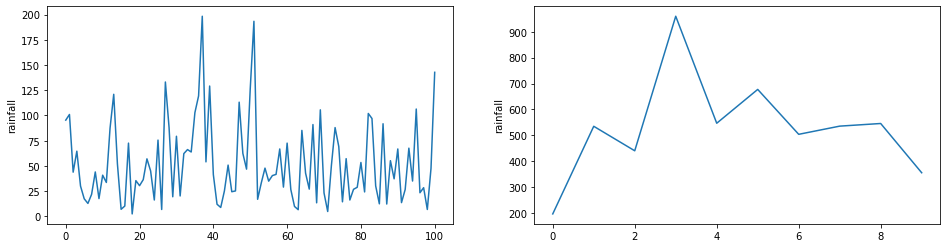

In [176]:
c = cities['Canberra']

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).sum().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).sum().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

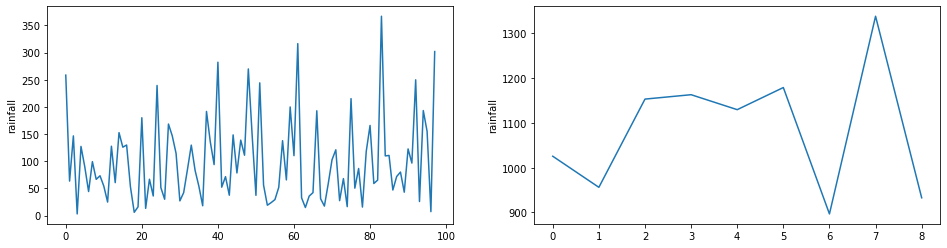

In [177]:
c = cities['Sydney']

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).sum().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).sum().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

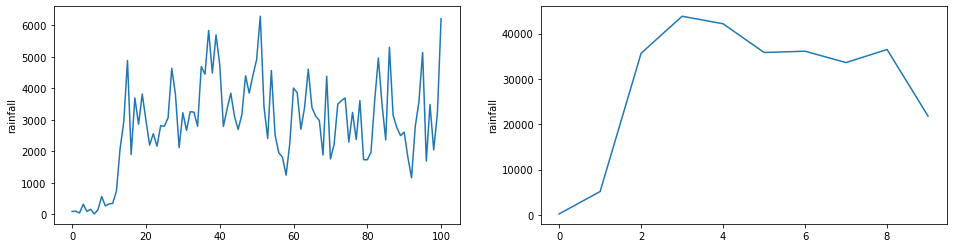

In [178]:
c = bob

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).sum().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).sum().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

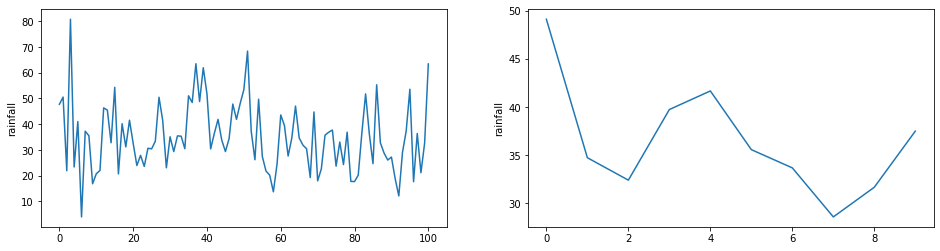

In [179]:
c = bob

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).mean().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).mean().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

Talvez implementar médias móveis

## Relationships Analysis

### **relationship *raintoday* and *rainfall***

*raintoday* seems to be derived from *rainfall*

In [17]:
xmax = data.loc[data.raintoday == 'No'].rainfall.max()
xmin = data.loc[data.raintoday == 'No'].rainfall.min()
yesmin = data.loc[data.raintoday == 'Yes'].rainfall.min()

In [18]:
print(f'minimum rainfall for necessary for raintoday = False: {xmin}')
print(f'maximum rainfall for necessary for raintoday = False: {xmax}')
print(f'minimum rainfall for necessary for raintoday = True: {yesmin}')

minimum rainfall for necessary for raintoday = False: 0.0
maximum rainfall for necessary for raintoday = False: 1.0
minimum rainfall for necessary for raintoday = True: 1.1


### **relationship *raintomorrow* and *amountOfRain***

*raintomorrow* seems to be derived from *amountOfRain*

In [19]:
x_true_min = data.loc[(data.raintomorrow == 'No')].amountOfRain.min()
x_true_max = data.loc[(data.raintomorrow == 'No')].amountOfRain.max()
x_false_min = data.loc[(data.raintomorrow == 'Yes')].amountOfRain.min()

In [20]:
print(f'minimum rainfall for necessary for raintomorrow = False: {x_true_min}')
print(f'maximum rainfall for necessary for raintomorrow = False: {x_true_max}')
print(f'minimum rainfall for necessary for raintomorrow = True: {x_false_min}')

minimum rainfall for necessary for raintomorrow = False: 0.0
maximum rainfall for necessary for raintomorrow = False: 1.0
minimum rainfall for necessary for raintomorrow = True: 1.1


### relationship *rainfall* and *amountOfRain*

However, if we consider rainfall being on time 'T' and amountOfRain bein on time 'T+1', if we bring them to the same time window, we can see a really high High correlation between 

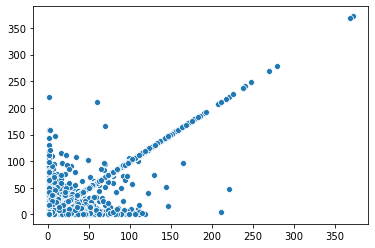

In [21]:
expectancy = np.array(data.amountOfRain[0:-1]) + 1
reality = np.array(data.rainfall[1:]) + 1

error = (expectancy - reality)/reality *100

sns.scatterplot(x=expectancy, y=reality)

### Discrepancy between rainfall/raintoday and raintomorrow/amountOfRain

Apart from the 1406 missing values of *rainfall*/*raintoday*, *raintomorrow*/*amountOfRain* should be
similar, since the seconds "would be" the first ones in a time t+1.

However, we have 13 rows with discrepant values between the two pairs!

In [22]:
pd.concat(  [data.rainfall[1:].reset_index(drop=True), 
             data.raintoday[1:].reset_index(drop=True),
             data.raintomorrow[0:-1].reset_index(drop=True),
             data.amountOfRain[0:-1].reset_index(drop=True)
            ],axis=1).dropna().query('raintoday != raintomorrow')

,rainfall,raintoday,raintomorrow,amountOfRain
2607,0.0,No,Yes,3.8
2609,3.8,Yes,No,0.0
2615,0.0,No,Yes,3.6
2617,3.6,Yes,No,0.0
2631,0.0,No,Yes,8.6
...,...,...,...,...
164114,2.8,Yes,No,0.2
164118,0.4,No,Yes,6.2
164120,6.2,Yes,No,0.2
164248,0.0,No,Yes,6.8


### temperature columns

In [23]:
# temperatura
# sns.pairplot(data.loc[:,['temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm']])

### pressure columns

In [24]:
pressure = data.loc[:,['pressure9am', 'pressure3pm']]
# sns.pairplot(pressure)

### humidity columns

In [25]:
humidity = data.loc[:,['humidity9am', 'humidity3pm', 'humidity']]
# sns.pairplot(humidity)

In [26]:
print('porcentagem de dados nulos:\n')
print(round(winds.isna().sum()/data.shape[0]*100))

porcentagem de dados nulos:

date              0.0
location          0.0
wind_gustdir      6.0
wind_gustspeed    6.0
wind_dir9am       7.0
wind_dir3pm       3.0
wind_speed9am     1.0
wind_speed3pm     2.0
dtype: float64


# Treating Data

## ~Separating: data for training and data for testing~

We will separate data, for not overfitting. For this reason we will reserve the last 366 days for testing.

In [27]:
# total = data.shape[0]
# data_testing = data.loc[data.date > '2016-06-24']
# data = data.loc[data.date <= '2016-06-24']

# print('rows reserved for training: ', round(data.shape[0]/total*100,2),'%')
# print('rows reserved for testing:', round(data_testing.shape[0]/total*100,2),'%')

rows reserved for training:  78.61 %
rows reserved for testing: 21.39 %


## Creating data:

**Treating: date column for datetime, raintoday and raintomorrow for binary categories**

In [99]:
# date string to date datetime:
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'])

# yes = 1, no = 0
data.loc[:,'raintoday'] = data.loc[:,'raintoday'].apply(lambda x: 0 if x == 'No' else x)
data.loc[:,'raintoday'] = data.loc[:,'raintoday'].apply(lambda x: 1 if x == 'Yes' else x)
data.loc[:,'raintomorrow'] = data.loc[:,'raintomorrow'].apply(lambda x: 0 if x == 'No' else x)
data.loc[:,'raintomorrow'] = data.loc[:,'raintomorrow'].apply(lambda x: 1 if x == 'Yes' else x)

**Create a columns for month and create a column for season**

In [22]:
data['month'] = data.loc[:,'date'].apply(lambda x: x.month)

seasons = {12:'Summer', 1:'Summer', 2:'Summer', 
             3:'Autumn', 4:'Autumn', 5:'Autumn',
             6:'Winter', 7:'Winter', 8:'Winter',
             9:'Spring', 10:'Spring', 11:'Spring'}

data['season'] = data.loc[:,'month'].apply(lambda x: seasons[x])

**Formating location**

- some locations need to be formated and words separated (i.e. BadgerysCreek to Badgerys Creek)

In [23]:
data['location'] = data['location'].str.replace(r"([A-Z]+)", r" \1").str.strip()

**Adding a mean value for the proportion of raining the next day for each city**

- *raintomo_mean*: will be the respective prob of rain the next day for the current city. Its the sum of 'raintomorro' by the total of rows of the city.

In [24]:
#get a df of mean prob of raining the next day for each city
rainto_mean = data[['location', 'raintomorrow']].groupby(by='location').mean().reset_index()

my_dict = {}

for loc in rainto_mean.location.unique():
    my_dict[loc] = round(rainto_mean.query(f'location == "{loc}"').raintomorrow.values[0],4)
    
data['loc_rainto_mean'] = data.location.apply(lambda x: my_dict[x])

**Adding a mean value for the proportion of raining the next day for each *wind_direction***

- *raintomo_mean*: will be the respective prob of rain the next day for the current city. Its the sum of 'raintomorro' by the total of rows of the city.

In [25]:
#get a df of mean prob of raining the next day for each wind_direction
wind_rainto_mean = data[['wind_gustdir', 'raintomorrow']].groupby(by='wind_gustdir').mean().reset_index()

for loc in wind_rainto_mean.wind_gustdir.unique():
    my_dict[loc] = round(wind_rainto_mean.query(f'wind_gustdir == "{loc}"').raintomorrow.values[0],4)
    
data['wind_rainto_mean'] = data.wind_gustdir.apply(lambda x: my_dict[x] if type(x) == str else x)

**Adding coorinates (*lat*, *lon*) columns and dropping *location***

- We will add latitude and longitude as a mean for transforming the location in numeric values, instead of using them with get_dummies.
- We won't need location anymore so we will drop them

In [26]:
geolocator = Nominatim(user_agent="my-application")

unique_loc = data['location'].unique()

for city in tqdm(unique_loc):
    geoloc = geolocator.geocode(city,'Australia')
    my_dict[city + '_lat'] = geoloc.latitude
    my_dict[city + '_lon'] = geoloc.longitude

data['location_lat'] = data.location.apply(lambda x: my_dict[x + '_lat'] if type(x) == str else x)
data['location_lon'] = data.location.apply(lambda x: my_dict[x + '_lon'] if type(x) == str else x)

100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


**Saving a backup csv**

In [29]:
data.to_csv('data_backup.csv',index=False)

**Loading backup when needed**

In [47]:
data = pd.read_csv('data_backup.csv')
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'])

## Discarding Data:

**Filling NaNs with mean values per city** > Bad idea???

At a first try, we will desconsider those columns columns. 38%, 40% of missing is close to half of the dataset!

Columns with more than 10% NaN are:

- evaporation         42.789026
- sunshine            47.692924
- cloud9am            37.735332
- cloud3pm            40.152469

We will consider to use them later, maybe the missing is only a zero value!

In [48]:
data = data.drop(['evaporation', 'sunshine', 'cloud9am', 'cloud3pm'],axis=1)

**Dropping some other columns**

- ***modelo_vigente***: this column is the results of a prediction model, we won't need it for fitting the model, only for further comparations

In [49]:
data = data.drop('modelo_vigente',axis=1)

In [ ]:
#um risco de usar um segundo modelo como variável nova, é voce ter seu modelo descalibrado depois.

**Dropping *temp***

*temp* is clearly dependend of the max temperature, and also has some missing values

In [50]:
data = data.drop('temp', axis=1)

**precipitacao nas ultimas 24h?**

supondo que a decisão é as 3 da tarde...

vai chover amanhã? à que horas do dia deve ser feito a previsão? 3 da tarde?

In [61]:
# data['prec_last_24h'] = data['precipitation3pm'] + data['precipitation9am']
# NO FIM NÂO MUDOU SCORE, PRATICAMENTE O MESMO!

In [ ]:
#verificar a relação de precipitation com raintomorro/raintoday

# Tobogã:

## Functions

**ACC PREC RECALL SCORES**

**ROC_CURVE**

**LEARNING CURVE**

In [156]:
def make_my_learn_curve(model, X_train, y_train, cv=KFold(10), scoring='roc_auc'):
    print('start:', datetime.now().strftime('%H:%M:%S'))

    curve = learning_curve(model, X_train, y_train, cv=KFold(10), scoring='roc_auc')
    
    train_sizes = curve[0]
    train_scores = curve[1]
    test_scores = curve[2]

    plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
    plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Test AUC')
    plt.ylim([0., 1])
    plt.xlabel('Training Sizes')
    plt.ylabel('Scores')
    plt.legend(loc=4)
    plt.grid()
    
    print('end:', datetime.now().strftime('%H:%M:%S'))


## Preparing Data: X and y (train and test) and comparison with *modelo_vigente*

In [51]:
fill_nas = False

#teste dataframe, no cities and no season!
teste = data.drop(['rainfall','amountOfRain',],axis=1)

before = teste.loc[teste.date <= '2016-06-24']
after = teste.loc[teste.date > '2016-06-24']

In [ ]:
#cuidado que imputar a média é usar valores futuros para previsão.
def fill_nas_with_mean(before):
    
    """
     Usar funções para deixar codigos visualmente mais autoexplicativos é uma boa solução, fica mais objetivo.
     o truque é usar a docstring da função para explicar.
    """
    
    #fill cloufs with zero   
#     teste['cloud9am'].fillna(0, inplace=True)
#     teste['cloud3pm'].fillna(0, inplace=True)
    
    #select float columns with NaN
    cols = list(before.loc[:,before.isna().any()].select_dtypes('float').columns)
    locs = before.location.unique()

    #filling NaN with mean values of the month
    deef = pd.DataFrame()

    for month in tqdm(np.arange(1,13)):
        for loc in locs:
            #query the df with location and month and store in a temporary df: lo_cdf
            lo_cdf = before.loc[:,['location'] + cols].loc[before.month == month].query(f'location == "{loc}"')

            #applying the modifications to lo_cdf
            lo_cdf.loc[:,cols] = lo_cdf.loc[:,cols].apply(lambda x: x.fillna(np.mean(x)), axis=1)

            #store in a dataframe
            deef = pd.concat([deef,lo_cdf])

    before.loc[:,['location'] + cols] = deef.sort_index()
    
    return before

In [53]:
# generate NaNs as mean, when needed: 
if fill_nas:
    
    before =  fill_nas_with_mean(before)
    
    before = before.drop(columns='location').dropna()
    after = after.drop(columns='location').dropna()
        
else:
    #now dropping
    before = before.drop(columns='location').dropna()
    after = after.drop(columns='location').dropna()


100%|██████████| 12/12 [03:16<00:00, 16.41s/it]


In [24]:
#saving a backup
teste = pd.concat([before,after])
teste.to_csv('teste_backup_0504.csv',index=False)

In [60]:
#loading backup when needed
teste = pd.read_csv('teste_backup_0504.csv')
before = teste.loc[teste.date <= '2016-06-24']
after = teste.loc[teste.date > '2016-06-24']

*REMINDER*: WE CAN KEEP 'raintoday' COLUMN SINCE WE WILL USE THE LAST YEAR FOR TESTING

In [61]:
#determine X and y
X_train = pd.get_dummies(before.drop(['raintomorrow','date'],axis=1))
y_train = before.loc[:,'raintomorrow']
    
X_test = pd.get_dummies(after.drop(['raintomorrow','date'],axis=1))
y_test = after.loc[:,'raintomorrow']

X_train.shape[1] == X_test.shape[1]

True

In [62]:
# Standardize data:
scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)

X_test_std = scaler.transform(X_test)

In [63]:
path = 'processo_cientista-master/data/'

#import modelo_vigente
modelo_vigente = pd.read_csv(path+'rain_data_aus.csv').dropna().modelo_vigente

## MODELO_VIGENTE ROC CURVE
dframe = pd.read_csv(path+'rain_data_aus.csv')
mv_y_pred_prob = dframe.modelo_vigente
mv_y_test = dframe.raintomorrow.apply(lambda x: 1 if x == 'Yes' else 0)

## PCA

each pca explains: [0.07877261 0.05191084]
Both components explain together 13.07% of the data

original shape:    (112925, 72)

transformed shape: (99128, 2)


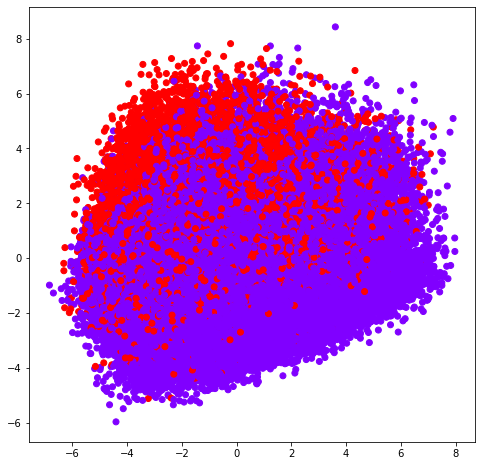

In [124]:
# instantiate and fit the pca object
X_std = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=2)
pca.fit(X_std)

print(f'each pca explains: {pca.explained_variance_ratio_}')
explains = pca.explained_variance_ratio_.sum()
print(f'Both components explain together {round(explains*100,2)}% of the data')

#now transform!
X_pca = pca.transform(X_std)

#check results
print("\noriginal shape:   ", X.shape)
print("\ntransformed shape:", X_pca.shape)
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]

fig, axe = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
axe.scatter(x=pc1, y=pc2, c=y_train, cmap='rainbow',)

## Taking the mean

In [23]:
the_mean = y_train.mean()
y_pred = y_train.apply(lambda x: the_mean).iloc[0:y_test.shape[0]]
y_pred = y_pred.apply(lambda x: 1 if x>0.5 else 0)

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
confusion_matrix(y_true= y_test, y_pred= y_pred)

array([[10583,     0],
       [ 3214,     0]], dtype=int64)

In [24]:
#(max_iter=100)
print('recall_score: ', recall_score(y_true= y_test, y_pred= y_pred))
print('precision_score: ', precision_score(y_true= y_test, y_pred= y_pred))
print('accuracy_score: ', accuracy_score(y_true= y_test, y_pred= y_pred))

recall_score:  0.0
precision_score:  0.0
accuracy_score:  0.7670508081466986


c:\users\vfarn\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic regression

In [64]:
#instantiate the model and fit
logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_std, y_train)

# let's evaluate - new data comes in:
predictions = logreg.predict(X_test_std)
pred_proba = logreg.predict_proba(X_test_std)

results = pd.DataFrame({'prob_not_rain': pred_proba[:,0], 
                          'prob_rain': pred_proba[:,1], 
                          'predictions':predictions,
                          'y_test':y_test})

accuracy_score(y_test, predictions)

0.8440965427266797

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
confusion_matrix(y_true= y_test, y_pred= predictions)

array([[9983,  600],
       [1551, 1663]], dtype=int64)

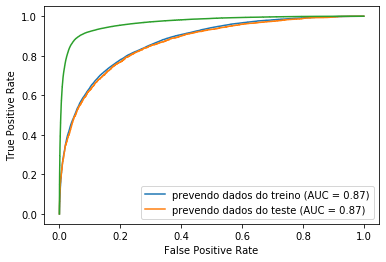

In [66]:
# results
fig, ax = plt.subplots()

plot_roc_curve(logreg, X_train_std, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(logreg, X_test_std, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.show();

start: 23:49:27
end: 23:51:22


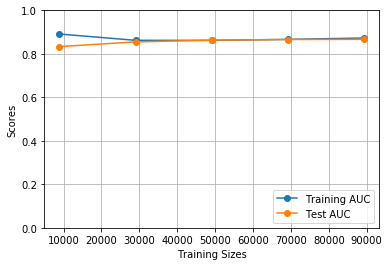

In [150]:
make_my_learn_curve(model=logreg, X_train=X_train_std, y_train=y_train)

## Decision Trees

Remember: we don't need to standardize the data here!




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:01<00:11,  1.45s/it]


 22%|██▏       | 2/9 [00:03<00:11,  1.63s/it]


 33%|███▎      | 3/9 [00:06<00:11,  1.96s/it]


 44%|████▍     | 4/9 [00:10<00:12,  2.57s/it]


 56%|█████▌    | 5/9 [00:15<00:13,  3.27s/it]


 67%|██████▋   | 6/9 [00:20<00:11,  3.83s/it]


 78%|███████▊  | 7/9 [00:25<00:08,  4.39s/it]


 89%|████████▉ | 8/9 [00:31<00:04,  4.87s/it]


100%|██████████| 9/9 [00:38<00:00,  4.29s/it]


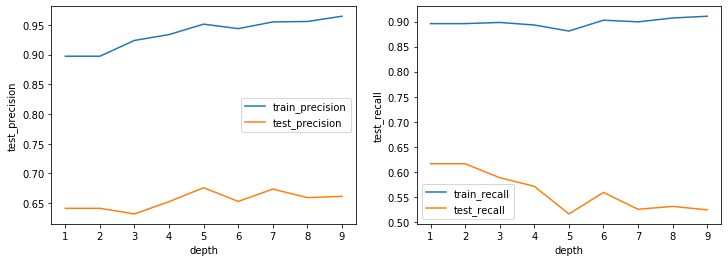

In [74]:
df = pd.DataFrame()

for N in tqdm(np.arange(1,10,1)):

    tree = DecisionTreeClassifier(max_depth=N)
    tree.fit(X_train, y_train)

    # TRAIN SET and get precision and recall
    tn, fp, fn, tp = confusion_matrix(y_train,tree.predict(X_train)).ravel()
    a1, a2 = tp / (fp + tp), tp / (fn + tp)

    # TEST SETand get precision, recall and test_score
    tn, fp, fn, tp = confusion_matrix(y_test,tree.predict(X_test)).ravel()
    a3, a4 = tp / (fp + tp), tp / (fn + tp)
    test_score = (tn + tp)/(tn + fp + fn + tp)


    minidf = pd.DataFrame({'depth':N, 'train_precision':a1, 
                          'train_recall':a2, 'test_precision':a3,
                          'test_recall':a4, 'test_score':test_score}, index=[0])
    df = pd.concat([df,minidf])
    
df = df.reset_index(drop=True)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

sns.lineplot(x='depth', y='train_precision', data=df, label = 'train_precision',ax=ax[0])
sns.lineplot(x='depth', y='train_recall', data=df, label = 'train_recall',ax=ax[1])
sns.lineplot(x='depth', y='test_precision', data=df, label = 'test_precision',ax=ax[0])
sns.lineplot(x='depth', y='test_recall', data=df, label = 'test_recall',ax=ax[1])

accuracy_score:  0.8332246140465318


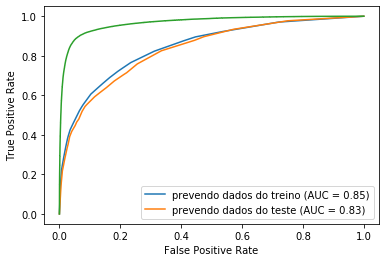

In [130]:
# fit with max_depth=7
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(tree, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(tree, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();

start: 23:52:32
end: 23:53:48


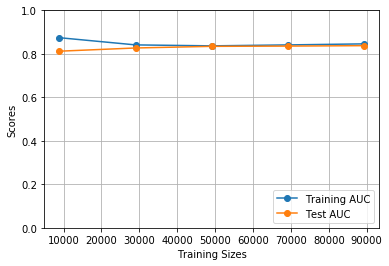

In [152]:
make_my_learn_curve(model=tree, X_train=X_train, y_train=y_train)

## Bagging

In [132]:
bagging = BaggingClassifier(
            base_estimator= None, #DecisionTreeClassifier(max_depth=3), 
            n_estimators=10,
            oob_score=True, n_jobs=-1)

In [133]:
print('start:', datetime.now().strftime('%H:%M:%S'))
results = cross_val_score(bagging, X_train, y_train, 
                          cv= KFold(10, shuffle=True), 
                          scoring='roc_auc')
(np.mean(results), np.std(results))
print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:28:16
end: 23:30:19


start: 23:30:21
accuracy_score:  0.8382257012393999


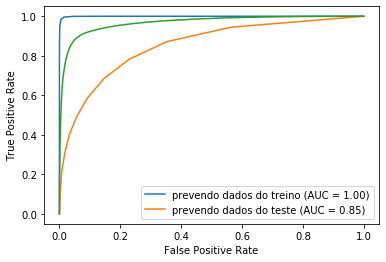

end: 23:30:37


In [134]:
print('start:', datetime.now().strftime('%H:%M:%S'))
bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(bagging, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(bagging, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();
print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:57:08
end: 00:03:47


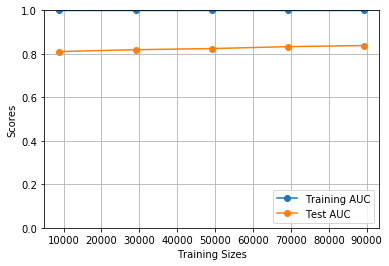

In [153]:
make_my_learn_curve(model=bagging, X_train=X_train, y_train=y_train)

## Random Forests

In [136]:
print('start:', datetime.now().strftime('%H:%M:%S'))

forest = RandomForestClassifier(max_depth=7, n_estimators=100, n_jobs=-1)

results = cross_val_score(forest, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:34:09
end: 23:35:06


start: 23:35:08
accuracy_score:  0.8358338769297673


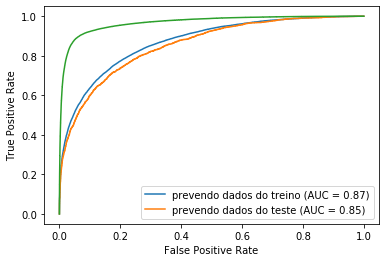

end: 23:35:15


In [137]:
print('start:', datetime.now().strftime('%H:%M:%S'))
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(forest, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(forest, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();
print('end:', datetime.now().strftime('%H:%M:%S'))

start: 00:31:18
end: 00:33:50


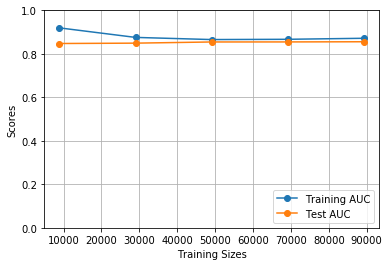

In [154]:
make_my_learn_curve(model=forest, X_train=X_train, y_train=y_train)

## Adaboost

In [139]:
print('start:', datetime.now().strftime('%H:%M:%S'))

adaboost = AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=50,
            learning_rate=.05)

print('adaboost ready!')

results = cross_val_score(adaboost, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:37:01
adaboost ready!


KeyboardInterrupt: 

In [ ]:
print('start:', datetime.now().strftime('%H:%M:%S'))
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(adaboost, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(adaboost, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();
print('end:', datetime.now().strftime('%H:%M:%S'))

In [155]:
make_my_learn_curve(model=adaboost, X_train=X_train, y_train=y_train)

start: 00:33:52


KeyboardInterrupt: 

## XGBoost

In [87]:
xgb = XGBClassifier(max_depth=1, 
                    n_estimators=50, 
                    colsample_bytree=0.7, 
                    n_jobs=-1)

NameError: name 'XGBClassifier' is not defined

In [ ]:
results = cross_val_score(xgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

In [ ]:
curves = learning_curve(xgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

## LightGBM

In [ ]:
lgb = LGBMClassifier(max_depth=1, n_estimators=100, colsample_bytree=.7, n_jobs=-1)

In [ ]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

In [ ]:
curves = learning_curve(lgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

In [ ]:
plot_importance(lgb, importance_type='gain')

## Manual log:
- mean() acc_score: 0.767051
- logreg acc_score: 0.844313
- logreg auc_test: 0.87
- tree acc_score: 0.83793578
- tree auc_test: 0.85

# Things to consider

Who is your client?

 > If the client is a simple person, how would you answer?

 > If the client is a farmer, wanting to collect his crops, how would you answer?

 > You should base this answers in propabilistc answers, by varying the % and precision and recall. % is the treshold.

What are you trying to answer?